# Registration
(teaching: 20 minutes)

### Questions:
- How do we register images of brains?

### Objectives
- "Understand what the SyN algorithm does to images"

### Key points:
- The SyN algorithm is a powerful algorithm for calculating diffeomorphic transformations between images
- It's particularly useful for registering images of brains

Another operation that we often want to do with neuroimages is registration.
We may want to register different images of the same brain to each other, or
images of different brains.

Though there are many algorithms to perform this registration, and your
motivations in selecting an algorithm may depend on what exactly it is that you
are trying to do, but one algorithm that is successful in many situations, and
has had success in [formal conparisons](http://www.ncbi.nlm.nih.gov/pubmed/19195496) is the Symmetric
Normalization (SyN) algorithm ([Avants et al. 2009](http://www.ncbi.nlm.nih.gov/pubmed/17659998)).

Though the canonical implementation of the algorithm is in the [ANTS]() Here, we'll use the implementation of the SyN algorithm in
[Dipy](http://dipy.org/) to understand a bit about what it does.

One of the strengths of the algorithm, that differentiates it from other
algorithms, is that instead of calculating a linear homogenous transform between
a moving image and a static image, the SyN algorithm calculates a deformation
field. That means that different . The algorithm makes sure that the
transformation is a
[diffeomorphism](https://en.wikipedia.org/wiki/Diffeomorphism), which means
that it is both invertible and smooth.

Let's see what that looks like with a really simple example
(based on [an example in the Dipy documentation](http://nipy.org/dipy/examples_built/syn_registration_2d.html#example-syn-registration-2d)):

In [1]:
import numpy as np
from dipy.data import get_data
import dipy.align.imwarp as imwarp
from dipy.viz import regtools
%matplotlib inline

fname_moving = get_data('reg_o')
fname_static = get_data('reg_c')

moving = np.load(fname_moving)
static = np.load(fname_static)

One of these will be defined as the image that moves and the other is the
comparison image to which things will be moved.

The `regtools` module has a helper function to visualize the two images side by
side, together with an overlay:

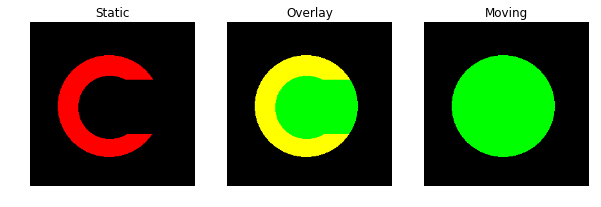

In [2]:
fig = regtools.overlay_images(static, moving, 'Static', 'Overlay', 'Moving')
fig.set_size_inches([10, 10])

The diffeomorphism will be found through optimization. A cost metric needs to be
defined to tell us whether we have found a good diffeomorphism.

The first decision we need to make is what similarity metric is appropriate for
our problem. In this example we are using two binary images, so the Sum of
Squared Differences (SSD) is a good choice (other options are cross-correlation
and mutual information).

In [3]:
from dipy.align.metrics import SSDMetric
metric = SSDMetric(static.ndim)

Next, we define an instance of the registration class. The SyN algorithm uses a
multi-resolution approach (essentially peforming the algorithm again and again
from a coarse resolution down to a fine resolution). We instruct the
registration instance to perform at most [n_0, n_1, ..., n_k] iterations at each
level of the pyramid, where the 0-th level corresponds to the finest resolution.

In [4]:
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
level_iters = [200, 100, 50, 25]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)

To execute the optimization, we call this registration object with our `moving`
and `static` input images

In [5]:
mapping = sdr.optimize(static, moving)

Creating scale space from the moving image. Levels: 4. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 4. Sigma factor: 0.200000.
Optimizing level 3
Optimizing level 2
Optimizing level 1
Optimizing level 0


To visualize the diffeomorphism, we can visualize the forward and inverse
transform encoded in the mapping

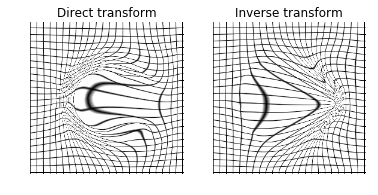

In [6]:
warped_forward, warped_back = regtools.plot_2d_diffeomorphic_map(mapping, 10)

We can test the success of the algorithm, by applying the transform to the moving object:

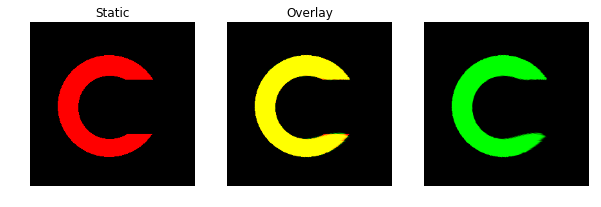

In [7]:
warped_moving = mapping.transform(moving)
fig = regtools.overlay_images(static, warped_moving, 'Static','Overlay')
fig.set_size_inches([10, 10])

The inverse transform can be used to go from the static to the moving image:

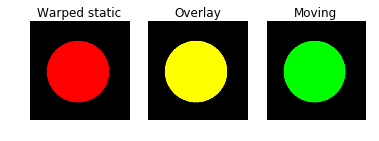

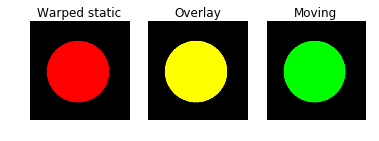

In [8]:
warped_static = mapping.transform_inverse(static, 'linear')
regtools.overlay_images(warped_static, moving,
                        'Warped static','Overlay','Moving',
                        'inverse_warp_result.png')

Now that we understand the principal, let's do this in practice on some brain
data. In this case, we'll use the data-sets that ship with Dipy. These are
data-sets from the brains of two different individuals:

On the first run of this, it will automatically download the data:

In [9]:
from dipy.data import fetch_stanford_hardi, read_stanford_hardi
fetch_stanford_hardi()
nib_stanford, gtab_stanford = read_stanford_hardi()
stanford_b0 = np.squeeze(nib_stanford.get_data())[..., 0]

from dipy.data.fetcher import fetch_syn_data, read_syn_data
fetch_syn_data()
nib_syn_t1, nib_syn_b0 = read_syn_data()
syn_b0 = np.array(nib_syn_b0.get_data())

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/.dipy/stanford_hardi 
Data size is approximately 12MB
Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/.dipy/syn_test 
Data size is approximately 12MB
Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/.dipy/syn_test 


To make the segmentation go better, we start by stripping the skull using the segmentation algorithms 
we saw before: 

In [10]:
from dipy.segment.mask import median_otsu
stanford_b0_masked, stanford_b0_mask = median_otsu(stanford_b0, 4, 4)
syn_b0_masked, syn_b0_mask = median_otsu(syn_b0, 4, 4)

static = stanford_b0_masked
static_affine = nib_stanford.get_affine()
moving = syn_b0_masked
moving_affine = nib_syn_b0.get_affine()

The SyN algorithm works much better if the brains are pre-aligned using a linear
approach (e.g., a an affine transformation). This transform will do:

In [11]:
pre_align = np.array([[1.02783543e+00, -4.83019053e-02, -
                       6.07735639e-02, -2.57654118e+00],
                      [4.34051706e-03, 9.41918267e-01,
                       -2.66525861e-01, 3.23579799e+01],
                      [5.34288908e-02, 2.90262026e-01,
                       9.80820307e-01, -1.46216651e+01],
                      [0.00000000e+00, 0.00000000e+00,
                       0.00000000e+00, 1.00000000e+00]])

from dipy.align.imaffine import AffineMap
affine_map = AffineMap(pre_align,
                       static.shape, static_affine,
                       moving.shape, moving_affine)

resampled = affine_map.transform(moving)

As before, we visualize the two images:

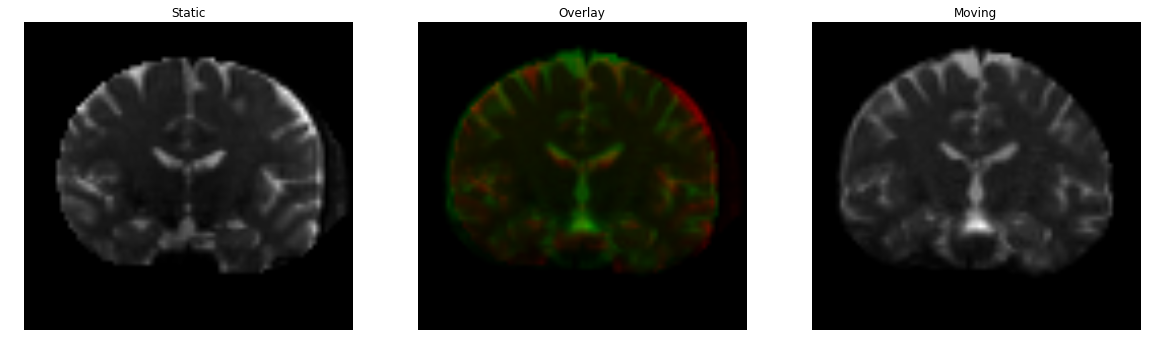

In [12]:
fig = regtools.overlay_slices(static, resampled, None, 1, 'Static', 'Moving')
fig.set_size_inches([20, 20])

Here, we will use the cross-correlation between the images as the metric.:

In [13]:
from dipy.align.metrics import CCMetric
metric = CCMetric(dim=3)

Again, we allocated the registration object:

In [14]:
level_iters = [10, 10, 5]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters)

and optimize it:

In [15]:
mapping = sdr.optimize(static, moving, static_affine, moving_affine, pre_align)

Creating scale space from the moving image. Levels: 3. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 3. Sigma factor: 0.200000.
Optimizing level 2
Optimizing level 1
Optimizing level 0


The moving image is transformed towards the static image:

In [16]:
warped_moving = mapping.transform(moving)

Looks good, considering it's two different brains!

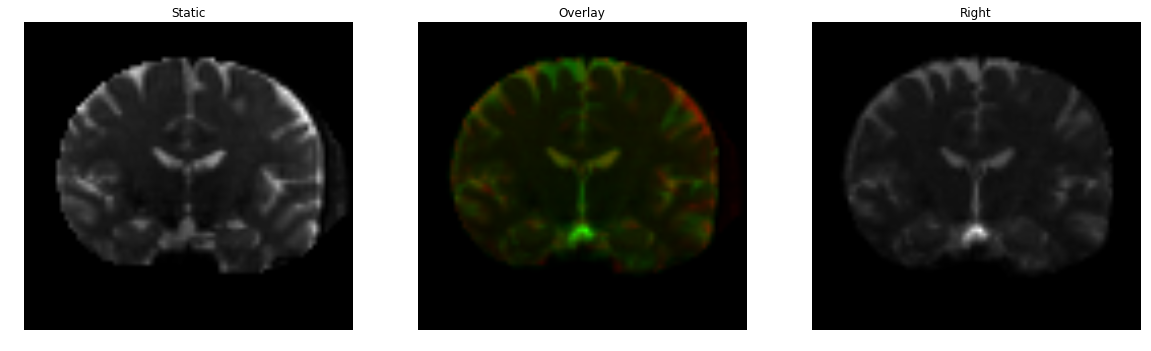

In [17]:
fig = regtools.overlay_slices(static, warped_moving, None, 1, 'Static')
fig.set_size_inches([20, 20])